### Warp, Threshold, and Map to Rover-Centric Coordinates
![process](process_to_rover-centric_coord.png)
从最原始的图片到映射至以rover为中心的（本地）坐标的导航地形图。   
Note: 左下方和右下方的图片代表的是相同的数据，但位于不同坐标系统上。

要获得环境地图，首先要应用透视变换，然后应用颜色阈值（反之亦然，这并不重要）。这个彩色阈值图像现在是Rover前面的可导航地形的地图！假设你通过组合前面两个练习中的函数（颜色阈值和透视变换）到达阈值二值图像，像这样：

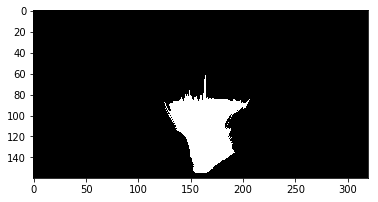

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import numpy as np
import cv2

from extra_functions import perspect_transform, color_thresh, source, destination

# Assume you have already defined perspect_transform() and color_thresh()
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160,160,160))

# plot the result
plt.imshow(colorsel, cmap='gray')
plt.show()

你现在从上面俯瞰着Rover的世界，白色区域显示的是你从Rover相机中看到的可导航地形。在这个图像中，漫游者相机的位置大致是（x，y）＝（160, 160）。（为什么实在这个位置，事实上是由根据的，只要，Rover上的相机是固定在Rover上的且位置不变，则Rover的相机在其拍摄到的图像上的位置是也是固定不变的，而且该位置能根据几何关系确定。）

#### Converting to Rover-Centric Coordinates（转换至Rover中心坐标系）
位置相对固定于机器人的坐标系的概念（local coordinate、局部坐标、本地坐标）是许多机器人应用的核心。该坐标系使你能够描述环境中的物体相对于机器人（在这个问题下，就是Rover或具体Rover的相机）的位置。    
在下一个任务中，需要提取所有可导航地形（白色）像素的像素位置，然后将这些值转换为“Rover中心”坐标，这意味着漫游者相机位于坐标（x，y）＝（0, 0）。     
可以通过以下方法获取图像中的像素位置：

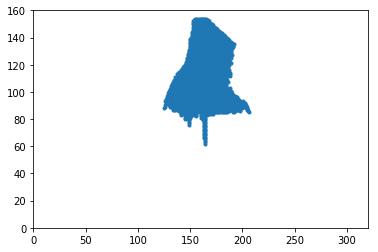

In [20]:
ypos, xpos = colorsel.nonzero()
plt.plot(xpos, ypos, '.')
plt.xlim(0, 320)
plt.ylim(0, 160)
plt.show()

但这是一个颠倒的图像！事实上这和之前希望得到的图像是一致的，只是现在坐标系的源点在下面，而y轴方向倒转了。（之前的图像使用plt.imshow(),这里的图像使用plt.plot()）     
现在拥有了可导航地形图像空间的x坐标和y坐标，下面需要做的就是把它转换成Rover中心坐标。但是，你还需要交换x轴和y轴，使它们与最终映射到的世界坐标系一致（注意这两幅颠倒的图像不是旋转180°关系，而是镜像关系）。     
下面的图像显示的是即将定义的Rover中心坐标系和世界坐标系，该坐标系是相对于世界固定的参考帧，也是我们将映射过去的坐标：    
![world_coordinate](world_coordinate.png)

下面先完成第一件事，即写一个方程，读进二值图像，然后提取图像中的x坐标和y坐标，最后返回Rover中心坐标系中的x坐标和y坐标。     
当你画出x_pixel和y_pixel时，应该得到类似下面的结果：
![result](result.png)

这种坐标的选择可能看起来不太直观,但现在当Rover位于(x_{world}, y_{world})=(0, 0)，并且偏航角为零时（偏航角以x轴正方向为基准，逆时针转为正方向），Rover确实和世界坐标系重叠。

Text(0.5,1,'Rover-Centric Map')

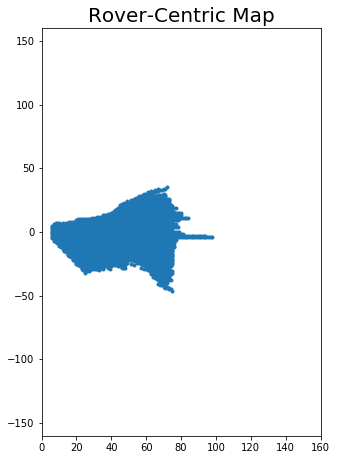

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from extra_functions import perspect_transform, color_thresh, source, destination

# Read in the sample image
image = mpimg.imread('sample.jpg')


def rover_coords(binary_img):
    # TODO: fill in this function to 
    # Calculate pixel positions with reference to the rover 
    # position being at the center bottom of the image. 
    x_pos, y_pos = binary_img.nonzero()
    y_pixel = -(y_pos-160)
    x_pixel = 160-x_pos
    return x_pixel, y_pixel

# Perform warping and color thresholding
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
# Extract x and y positions of navigable terrain pixels
# and convert to rover coordinates
xpix, ypix = rover_coords(colorsel)

# Plot the map in rover-centric coords
fig = plt.figure(figsize=(5, 7.5))
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
plt.title('Rover-Centric Map', fontsize=20)
#plt.show() # Uncomment if running on your local machine

结果似乎不错，下面看看solution是怎么处理的。     
可以看到，也是一系列简单变换，例如反转(-)和平移(+-values)变换的组合。

In [ ]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position 
    # being at the center bottom of the image.
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

注意交换x坐标和y坐标对图像的变换结果、镜像图像：   

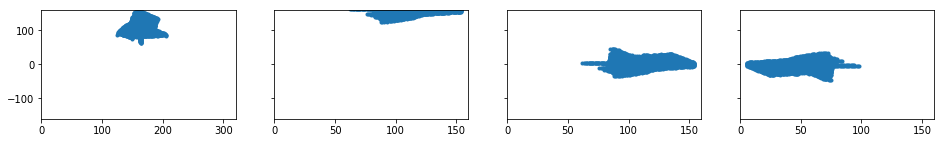

In [41]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 2), sharey=True)

# raw image
ypos, xpos = colorsel.nonzero()
ax1.plot(xpos, ypos, '.')
ax1.set_xlim(0, 320)
ax1.set_ylim(0, 160)

# just swap x and y
xpos_re = ypos
ypos_re = xpos
ax2.plot(xpos_re, ypos_re, '.')
ax2.set_xlim(0, 160)
ax2.set_ylim(0, 320)

# swap and translate
xpos_rt = xpos_re
ypos_rt = ypos_re - 160
ax3.plot(xpos_rt, ypos_rt, '.')
ax3.set_xlim(0, 160)
ax3.set_ylim(0, 320)

# swap and translate and mirror
x_pixel = -(ypos - image.shape[0]).astype(np.float)
y_pixel = -(xpos - image.shape[1]/2 ).astype(np.float)
ax4.plot(x_pixel, y_pixel, '.')
ax4.set_xlim(0, 160)
ax4.set_ylim(-160, 160)

plt.show()

注：Axes class 通过set_lim来设置坐标轴区间；matplotlib.pyplot（即plt）通过x_lim和y_lim来设置坐标轴区间，设置的是对象是 current axes！